<a href="https://colab.research.google.com/github/regitanina/ANALISIS-SENTIMEN-LSTM-DAN-GLOVE/blob/main/FASE_2_(Glove_LSTM)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/IndoNLP/indonlu.git
%cd indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 509 (delta 119), reused 139 (delta 110), pack-reused 316 (from 1)
Receiving objects: 100% (509/509), 9.46 MiB | 6.30 MiB/s, done.
Resolving deltas: 100% (239/239), done.
/content/indonlu


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 16.1 MB/s eta 0:00:00
  C

In [ ]:
!ls

CODE_OF_CONDUCT.md   examples  predict.py    requirements.txt	  tutorial
CONTRIBUTING.md      LICENSE   predict.sh    run_all_tasks.sh	  utils
dataset		     main.py   README.id.md  run_single_task.sh
data_utils_notebook  modules   README.md     submission_examples


##Import Library

#LABELLING DATASET

In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from sklearn.metrics import classification_report

# Menambahkan path untuk mengakses module dari folder content
sys.path.append('/content')

# Mengimpor class dan fungsi dari skrip buatan sendiri
from utils.forward_fn import forward_sequence_classification
from utils.metrics import document_sentiment_metrics_fn
from utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load Tokenizer


In [ ]:
# Load Tokenizer dan Konfigurasi
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = 3  # Negatif, Netral, Positif

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

##Load Model Training

In [ ]:
# Load Model
model_path = '/content/drive/MyDrive/Colab Notebooks/Skripsi/Model/Model_1.pt'
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)
model.load_state_dict(torch.load(model_path, map_location='cpu'))  # Atur map_location agar fleksibel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

##Load Dataset Privat

In [ ]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset Privat/dataset_privat.csv')
df_asli = df.copy()
df['Review'] = df['Review'].astype(str).str.lower()

##Mapping Label

In [ ]:
DocumentSentimentDataset.LABEL2INDEX = {'negatif': 0, 'netral': 1, 'positif': 2}
DocumentSentimentDataset.INDEX2LABEL = {0: 'negatif', 1: 'netral', 2: 'positif'}

In [ ]:
# Mapping label dari kelas
w2i = DocumentSentimentDataset.LABEL2INDEX
i2w = DocumentSentimentDataset.INDEX2LABEL

##Fungsi Prediksi

In [ ]:
# Fungsi Prediksi
def predict_sentiment(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=128
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    label_id = torch.argmax(outputs.logits, dim=1).item()
    return i2w[label_id]

In [ ]:
# Terapkan Prediksi
df['sentiment'] = df['Review'].apply(predict_sentiment)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
# Tampilkan distribusi hasil prediksi
print(df['sentiment'].value_counts(normalize=True))

sentiment
positif    0.516921
negatif    0.442140
netral     0.040939
Name: proportion, dtype: float64


##Hasil Labelling

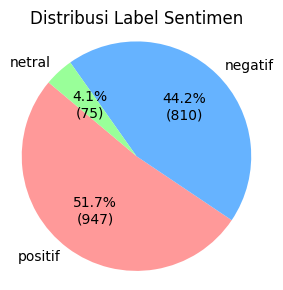

In [ ]:
import matplotlib.pyplot as plt

# Hitung distribusi label sentimen
label_counts = df['sentiment'].value_counts()
total = label_counts.sum()

# Fungsi untuk menampilkan presentase + jumlah
def autopct_format(pct):
    count = int(round(pct * total / 100.0))
    return f'{pct:.1f}%\n({count})'

# Plot pie chart
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct=autopct_format,
        startangle=140, colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Distribusi Label Sentimen')
plt.axis('equal')  # Biar bentuknya bulat sempurna
plt.tight_layout()
plt.show()


In [ ]:
df_awal = df.copy()  # simpan sebelum preprocessing
print(df_awal['sentiment'].value_counts())

sentiment
positif    947
negatif    810
netral      75
Name: count, dtype: int64


In [ ]:
# Simpan ke file baru
df.to_csv("/content/data_labelling.csv", index=False)

print("✅ Sentimen berhasil diprediksi dan disimpan ke file baru.")

✅ Sentimen berhasil diprediksi dan disimpan ke file baru.


#PREPROCESSING

##Import Dataset Hasil Labelling

In [ ]:
import pandas as pd
df = pd.read_csv("/content/data_labelling.csv")

## Cleaning

In [ ]:
# Buang data kosong di kolom 'Review'
import re
df = df.dropna(subset=['Review'])
df = df[df['Review'].str.strip() != '']

In [ ]:
# Cleaning
df['clean'] = df['Review'].apply(lambda x: re.sub(r'http\S+', '', x))        # hapus URL
df['clean'] = df['clean'].apply(lambda x: re.sub(r'@\w+', '', x))                 # hapus mention
df['clean'] = df['clean'].apply(lambda x: re.sub(r'#\w+', '', x))                 # hapus hashtag
df['clean'] = df['clean'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))             # hapus tanda baca
df['clean'] = df['clean'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())         # hapus spasi ganda dan trim


# Tampilkan hasil untuk cek
df[['Review', 'clean', 'sentiment']].head()


,Review,clean,sentiment
0,viewnya sangat baguss cocok untuk liburan kelu...,viewnya sangat baguss cocok untuk liburan kelu...,positif
1,"baguusss udah beberapa kali ke sini, hawanya d...",baguusss udah beberapa kali ke sini hawanya di...,negatif
2,kesini bareng temen lewat jalan yang gaperlu b...,kesini bareng temen lewat jalan yang gaperlu b...,netral
3,ini adalah pengalaman pertama saya dan familiy...,ini adalah pengalaman pertama saya dan familiy...,negatif
4,suka,suka,positif


##Tokenisasi

In [ ]:
# Tokenisasi kata
df['token'] = df['clean'].apply(lambda x: x.split())
# Lihat hasil
df[['clean','token']].head()

,clean,token
0,viewnya sangat baguss cocok untuk liburan kelu...,"[viewnya, sangat, baguss, cocok, untuk, libura..."
1,baguusss udah beberapa kali ke sini hawanya di...,"[baguusss, udah, beberapa, kali, ke, sini, haw..."
2,kesini bareng temen lewat jalan yang gaperlu b...,"[kesini, bareng, temen, lewat, jalan, yang, ga..."
3,ini adalah pengalaman pertama saya dan familiy...,"[ini, adalah, pengalaman, pertama, saya, dan, ..."
4,suka,[suka]


##Normalisasi

In [ ]:
# Tambahkan kamus manual
slang_manual = {
    'tdk': 'tidak',
    'udh': 'sudah',
    'sdh': 'sudah',
    'blm': 'belum',
    'dgn': 'dengan',
    'sm': 'sama',
    'aj': 'saja',
    'jg': 'juga',
    'byk': 'banyak',
    'pok': 'pokoknya',
    'sebelhmnya': 'sebelumnya',
    'dingkan': 'dingin',
    'aduhm': 'haduh',
    'ko': 'kamu',
    'km': 'kamu',
    'loe': 'kamu',
    'gw': 'saya',
    'gue': 'saya',
    'sy': 'saya',
    'diperjalan': 'diperjalanan',
    'pake': 'pakai',
    'gung': 'gunung',
    'ccok': 'cocok',
    'bund': 'bunda',
    'jt': 'juta',
    'poknya': 'pokoknya',
    'ramee': 'ramai',
    'jan': 'dan',
    'yng': 'yang',
    'bbrp': 'beberapa',
    'yg': 'yang',
    'dr': 'dari',
    'dlm': 'dalam',
    'klo': 'kalau',
    'kalo': 'kalau',
    'kl': 'kalau',
    'klu': 'kalau',
    'tp': 'tapi',
    'tpi': 'tapi',
    'pdhl': 'padahal',
    'bgt': 'banget',
    'bangt': 'banget',
    'cm': 'cuma',
    'mksih': 'terimakasih',
    'y': 'iya',
    'ya': 'iya',
    'ane': 'saya',
    'org': 'orang',
    'krn': 'karena',
    'karna': 'karena',
    'trs': 'terus',
    'trus': 'terus',
    'ntr': 'nanti',
    'bgtu': 'begitu',
    'bgini': 'begini',
    'begono': 'begitu',
    'blg': 'bilang',
    'lg': 'lagi',
    'surve': 'survei',
    'faforit': 'favorit',
    'bsok': 'besok',
    'bsok2': 'lain kali',
    'td': 'tadi',
    'tuh': 'itu',
    'nih': 'ini',
    'stengah': 'setengah',
    'jm': 'jam',
    'lsg': 'langsung',
    'dg': 'dengan',
    'yg': 'yang',
    'keling': 'keliling',
    'skrg': 'sekarang',
    'sekrang': 'sekarang',
    'dr': 'dari',
    'dlm': 'dalam',
    'klo': 'kalau',
    'kl': 'kalau',
    'klu': 'kalau',
    'btw': 'omong-omong',
    'tp': 'tapi',
    'tpi': 'tapi',
    'pdhl': 'padahal',
    'ajaib': 'aneh',
    'bgt': 'banget',
    'bangt': 'banget',
    'cm': 'cuma',
    'ok': 'baik',
    'y': 'iya',
    'bgtu': 'begitu',
    'bgini': 'begini',
    'begono': 'begitu',
    'blg': 'bilang',
    'lg': 'lagi',
    'lagi2': 'lagi-lagi',
    'kmrn': 'kemarin',
    'bsok': 'besok',
    'bsok2': 'lain kali',
    'td': 'tadi',
    'pricey': 'mahal',
    'nnggu': 'nunggu',
    'tmptnya': 'tempatnya',
    'utk': 'untuk',
    'krna': 'karena',
    'dri': 'dari',
    'kli': 'kali',
    'pling': 'paling',
    'gungya': 'gunungnya',
    'nhinep': 'menginap',
    'cri': 'cari',
    'smpe': 'sampai',
    'ak': 'aku',
    'dpet': 'dapat',
    'gppa': 'gapapa',
    'banged': 'banget',
    'dingkan': 'dingin',
    "rp": "rupiah",
    "bikkan": "bikin",
    "pedangang": "pedagang",
    "minibus": " mini bus",
    "duduk2": "duduk duduk",
    "mengadep": "menghadap",
    "oct": "oktober",
    "sngat": "sangat",
    "jm": "jam",
    "minim": "kurang",
    "krasan": "betah",
    "dengab": "dengan",
    "ktk": "ketika",
    "htm": "harga",
    "dkt": "dekat",
    "sep": "september",
    "mbois": " ",
    "rf": " ",
    "jd": "jadi",
    "bgt": "banget",
    "berpa": "berapa",
    "mengbrol": "mengobrol",
}


In [ ]:
def preprocessing_normalization(tokens):
    new_token = []
    skip = False

    for i, token in enumerate(tokens):
        if skip:
            skip = False
            continue

        # Gabungan 2 kata (misalnya: "ga mau")
        if i + 1 < len(tokens):
            double = f"{token} {tokens[i+1]}"
            if double in slang_manual:
                new_token.extend(slang_manual[double].split())
                skip = True
                continue

        # Cek 1 kata
        token_lower = token.lower()
        if token_lower in slang_manual:
            replacement = slang_manual[token_lower]
            if replacement:
                new_token.extend(replacement.split())
        else:
            new_token.append(token)

    return new_token

df['normalized'] = df['token'].apply(preprocessing_normalization)
df[['token','normalized']].head()

,token,normalized
0,"[viewnya, sangat, baguss, cocok, untuk, libura...","[viewnya, sangat, baguss, cocok, untuk, libura..."
1,"[baguusss, udah, beberapa, kali, ke, sini, haw...","[baguusss, udah, beberapa, kali, ke, sini, haw..."
2,"[kesini, bareng, temen, lewat, jalan, yang, ga...","[kesini, bareng, temen, lewat, jalan, yang, ga..."
3,"[ini, adalah, pengalaman, pertama, saya, dan, ...","[ini, adalah, pengalaman, pertama, saya, dan, ..."
4,[suka],[suka]


In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.0 MB/s eta 0:00:00


##Stemming

In [ ]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Buat stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Gabungkan token normalisasi
df['normalized_join'] = df['normalized'].apply(lambda x: ' '.join(x))

# Lakukan stemming
df['stemmed'] = df['normalized_join'].apply(lambda x: stemmer.stem(x))

In [ ]:
# Lihat hasil
df[['normalized_join', 'stemmed']].head()

,normalized_join,stemmed
0,viewnya sangat baguss cocok untuk liburan kelu...,viewnya sangat baguss cocok untuk libur keluar...
1,baguusss udah beberapa kali ke sini hawanya di...,baguusss udah beberapa kali ke sini hawa dingi...
2,kesini bareng temen lewat jalan yang gaperlu b...,kesini bareng temen lewat jalan yang gaperlu b...
3,ini adalah pengalaman pertama saya dan familiy...,ini adalah alam pertama saya dan familiy ke te...
4,suka,suka


In [ ]:
!pip uninstall -y nltk
!pip install nltk

Found existing installation: nltk 3.4.5
Uninstalling nltk-3.4.5:
  Successfully uninstalled nltk-3.4.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade nltk

##Stopwords Removal

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords bahasa Indonesia (hanya perlu sekali)
nltk.download('stopwords')

# Ambil daftar stopwords bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Terapkan stopwords removal
df['final_clean'] = df['stemmed'].apply(remove_stopwords)

# Lihat hasil
df[['stemmed', 'final_clean']].head(5)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,stemmed,final_clean
0,viewnya sangat baguss cocok untuk libur keluar...,viewnya baguss cocok libur keluarga temen teme...
1,baguusss udah beberapa kali ke sini hawa dingi...,baguusss udah kali hawa dingin boat 1x putar 8...
2,kesini bareng temen lewat jalan yang gaperlu b...,kesini bareng temen jalan gaperlu bayar tiket ...
3,ini adalah alam pertama saya dan familiy ke te...,alam familiy telaga sarangan
4,suka,suka


##Hasil Preprocessing

In [ ]:
# Bandingkan Hasil
print("Jumlah sebelum preprocessing:")
print(df_awal['sentiment'].value_counts())

print("\nJumlah setelah preprocessing:")
print(df['sentiment'].value_counts())


Jumlah sebelum preprocessing:
sentiment
positif    947
negatif    810
netral      75
Name: count, dtype: int64

Jumlah setelah preprocessing:
sentiment
negatif    810
positif    342
netral      75
Name: count, dtype: int64


In [ ]:
# Menyimpan hasil ke file CSV
df.to_csv("/content/Cleaning_Data.csv", index=False)

print("✅ Sentimen berhasil diprediksi dan disimpan ke file baru di folder yang sesuai.")


✅ Sentimen berhasil diprediksi dan disimpan ke file baru di folder yang sesuai.


#Word Embedding Glove

In [ ]:
# Instalasi dan Kompilasi Tool GloVe
!git clone https://github.com/stanfordnlp/GloVe.git
%cd GloVe
!make

Cloning into 'GloVe'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 705 (delta 57), reused 49 (delta 46), pack-reused 614 (from 2)
Receiving objects: 100% (705/705), 264.83 KiB | 1008.00 KiB/s, done.
Resolving deltas: 100% (398/398), done.
/content/indonlu/GloVe
mkdir -p build
gcc -c src/vocab_count.c -o build/vocab_count.o -pthread -O3 -march=native -funroll-loops -Wall -Wextra -Wpedantic
gcc -c src/cooccur.c -o build/cooccur.o -pthread -O3 -march=native -funroll-loops -Wall -Wextra -Wpedantic
src/cooccur.c: In function ‘merge_files’:
src/cooccur.c:180:9: warning: ignoring return value of ‘fread’ declared with attribute ‘warn_unused_result’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-result-Wunused-result]8;;]
  180 |         fread(&new, sizeof(CREC), 1, fid[i]);
      |         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
src/cooccur.c:190:5: warning: ig

In [ ]:
import pandas as pd
import re

# Load dataset
df = pd.read_csv('/content/Cleaning_Data.csv')  # sesuaikan nama file jika berbeda

# Gabungkan dan simpan sebagai 1 file teks (korpus)
with open('/content/corpus.txt', 'w') as f:
    for line in df['final_clean'].dropna():
        cleaned = line
        f.write(cleaned + '\n')


In [ ]:
# Buat vocab dari korpus
!./build/vocab_count -min-count 5 -max-vocab 100000 -verbose 2 < /content/corpus.txt > /content/vocab.txt

# Bangun co-occurrence matrix
!./build/cooccur -memory 4.0 -vocab-file /content/vocab.txt -window-size 10 -verbose 2 < /content/corpus.txt > /content/cooccurrence.bin

# Acak co-occurrence
!./build/shuffle -memory 4.0 -verbose 2 < /content/cooccurrence.bin > /content/cooccurrence.shuf.bin

# Latih model GloVe
!./build/glove -save-file /content/glove_vector -threads 4 -input-file /content/cooccurrence.shuf.bin -x-max 10 -iter 15 -vector-size 100 -binary 0 -vocab-file /content/vocab.txt -verbose 2


BUILDING VOCABULARY
Processed 0 tokens.Processed 12646 tokens.
Counted 2220 unique words.
Truncating vocabulary at min count 5.
Using vocabulary of size 421.

COUNTING COOCCURRENCES
window size: 10
context: symmetric
max product: 13752509
overflow length: 38028356
Reading vocab from file "/content/vocab.txt"...loaded 421 words.
Building lookup table...table contains 177242 elements.
Processing token: 0Processed 12646 tokens.
Writing cooccurrences to disk.....2 files in total.
Merging cooccurrence files: processed 0 lines.0 lines.Merging cooccurrence files: processed 43342 lines.

Using random seed 1754034368
SHUFFLING COOCCURRENCES
array size: 255013683
Shuffling by chunks: processed 0 lines.processed 43342 lines.
Wrote 1 temporary file(s).
Merging temp files: processed 0 lines.43342 lines.Merging temp files: processed 43342 lines.

TRAINING MODEL
Read 43342 lines.
Initializing parameters...Using random seed 1754034368
done.
vector size: 100
vocab size: 421
x_max: 10.000000
alpha: 0.75

In [ ]:
# Load hasil embedding ke dictionary
word_vectors = {}
with open('/content/glove_vector.txt', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = list(map(float, values[1:]))
        word_vectors[word] = vector

# Contoh penggunaan
import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

print("Kosakata vektor tersedia:", len(word_vectors))
print("Contoh vektor 'bagus':", word_vectors.get('bagus'))

# Cari kata paling mirip dengan 'bagus'
target = 'bagus'
target_vec = word_vectors[target]
similarities = {
    word: cosine_similarity(target_vec, vec)
    for word, vec in word_vectors.items()
    if word != target
}
similar_top = sorted(similarities.items(), key=lambda x: -x[1])[:5]
print("Kata mirip 'bagus':", similar_top)


Kosakata vektor tersedia: 422
Contoh vektor 'bagus': [0.070823, -0.341003, 0.186185, -0.265686, -0.18813, 0.654749, -0.262279, 0.26124, -0.297096, 0.198106, 0.159338, -0.227429, -0.055127, -0.195232, 0.294476, -0.007498, -0.035037, -0.135034, 0.778124, -0.095253, 0.270734, 0.0497, -0.000525, -0.136344, 0.112413, 0.164603, 0.049797, -0.247708, 0.326043, 0.06663, -0.101522, -0.235422, -0.000168, 0.154194, 0.045913, 0.430036, -0.167916, 0.720108, 0.202292, -0.099074, -0.40853, -0.111875, -0.309774, 0.038757, 0.207541, 0.005403, 0.106772, -0.288081, -0.12021, -0.213008, 0.5867, -0.410998, 0.124998, 0.332671, 0.139589, 0.197564, 0.39743, -0.248965, -0.000809, -0.598236, -0.033314, 0.090915, 0.045623, 0.054473, 0.07472, -0.043486, 0.16641, 0.095369, -0.04119, 0.223235, 0.278964, 0.027081, 0.198312, 0.057873, 0.156661, -0.092814, 0.099309, -0.242544, -0.047809, 0.218875, -0.046252, -0.230684, 0.094869, 0.088905, 0.104985, 0.697302, 0.167242, -0.000269, 0.099047, 0.483746, 0.727184, 0.246043, 

#Oversampling

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Load dataset
df = pd.read_csv('/content/Cleaning_Data.csv')

##Split Data (70,15,15)

In [ ]:
import tensorflow as tf

In [ ]:
# Set Seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Split Data
X = df['final_clean'].fillna('').astype(str)
Y = df['sentiment']

# Split 70-15-15
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=seed)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.50, stratify=Y_temp, random_state=seed)

##Cek Distribusi Data

In [ ]:
from collections import Counter

def show_label_distribution(name, y):
    total = len(y)
    counts = Counter(y)
    print(f"\nDistribusi label pada {name}:")
    for label, count in counts.items():
        print(f"  Label {label}: {count} data ({(count/total)*100:.2f}%)")

show_label_distribution("Training Set", Y_train)
show_label_distribution("Validation Set", Y_val)
show_label_distribution("Test Set", Y_test)



Distribusi label pada Training Set:
  Label negatif: 566 data (65.97%)
  Label positif: 239 data (27.86%)
  Label netral: 53 data (6.18%)

Distribusi label pada Validation Set:
  Label positif: 51 data (27.72%)
  Label negatif: 122 data (66.30%)
  Label netral: 11 data (5.98%)

Distribusi label pada Test Set:
  Label negatif: 122 data (65.95%)
  Label positif: 52 data (28.11%)
  Label netral: 11 data (5.95%)


##Count Sebelum Oversampling

In [ ]:
# Count distribusi label sebelum oversampling
original_counts = pd.Series(Y_train).value_counts().sort_index()
print("Distribusi Label Sebelum Oversampling:")
print(original_counts)

Distribusi Label Sebelum Oversampling:
sentiment
negatif    566
netral      53
positif    239
Name: count, dtype: int64


##Balancing Data

In [ ]:
# Oversampling RandomOverSampler
ros = RandomOverSampler(random_state=seed)
X_train_resampled, Y_train_resampled = ros.fit_resample(X_train.to_frame(), Y_train)


##Count Setelah Oversampling

In [ ]:
# Count distribusi label setelah oversampling
oversampled_counts = pd.Series(Y_train_resampled).value_counts().sort_index()
print("Distribusi Label Setelah Oversampling:")
print(oversampled_counts)

Distribusi Label Setelah Oversampling:
sentiment
negatif    566
netral     566
positif    566
Name: count, dtype: int64


##Hasil Distribusi Oversampling

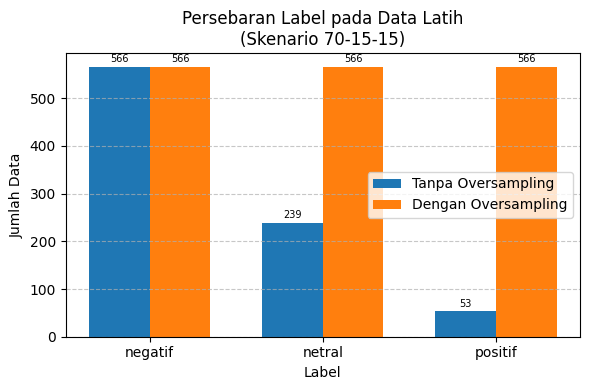

In [ ]:
# Definisikan label_names jika belum ada
label_names = ['negatif', 'netral', 'positif']

# Hitung distribusi label asli
original_counts = Y_train.value_counts()

# Hitung distribusi label setelah oversampling
oversampled_counts = pd.Series(Y_train_resampled).value_counts()

# Buat DataFrame untuk visualisasi
df_vis = pd.DataFrame({
    'Label': label_names,
    'Original': original_counts.values,
    'Oversampled': oversampled_counts.values
})

# Plot
plt.figure(figsize=(6, 4))
bar_width = 0.35
x = range(len(df_vis))

# Bar Original
bars1 = plt.bar(x, df_vis['Original'], width=bar_width, label='Tanpa Oversampling')
# Bar Oversampled
bars2 = plt.bar([i + bar_width for i in x], df_vis['Oversampled'], width=bar_width, label='Dengan Oversampling')

# Tambahkan jumlah data di atas setiap batang
for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(df_vis['Original'][i]), ha='center', va='bottom', fontsize=7)

for i, bar in enumerate(bars2):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(df_vis['Oversampled'][i]), ha='center', va='bottom', fontsize=7)

# Label dan tampilan
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.title('Persebaran Label pada Data Latih\n(Skenario 70-15-15)')
plt.xticks([i + bar_width / 2 for i in x], df_vis['Label'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#LSTM

##Import Library

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Tokenizer + Sequence
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_resampled['final_clean'])

X_train_seq = tokenizer.texts_to_sequences(X_train_resampled['final_clean'])
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Hitung panjang sequence 95 percentile
sequence_lengths = [len(seq) for seq in X_train_seq]
max_length = int(np.percentile(sequence_lengths, 95))

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


In [ ]:
# Encode Label
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train_resampled)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)

Y_train_ohe = to_categorical(Y_train_encoded, num_classes=3)
Y_val_ohe = to_categorical(Y_val_encoded, num_classes=3)
Y_test_ohe = to_categorical(Y_test_encoded, num_classes=3)

##Load Glove

In [ ]:
# Load Pre-trained GloVe dan Buat Embedding Matrix
embedding_index = {}
with open('/content/glove_vector.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# Ekstraksi Vektor Embedding dari File Teks GloVe
vector = np.asarray(values[1:], dtype='float32')

In [ ]:
# Deteksi Otomatis Dimensi Embedding dari GloVe
embedding_dim = len(next(iter(embedding_index.values())))
print("Embedding dimensi:", embedding_dim)

Embedding dimensi: 100


In [ ]:
# Pembangunan Matriks Embedding Sesuai Tokenizer
vocab_size = len(tokenizer.word_index) + 1  # +1 untuk token 0
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("embedding_matrix shape:", embedding_matrix.shape)  # Harus (vocab_size, 100)


embedding_matrix shape: (1833, 100)


In [ ]:
# Evaluasi Cakupan Vocabulary Tokenizer dalam GloVe
found = sum((1 for word in tokenizer.word_index if word in embedding_index))
print(f"Jumlah kata ditemukan di GloVe: {found} dari {vocab_size}")

Jumlah kata ditemukan di GloVe: 421 dari 1833


##Model LSTM

##Pelatihan & Pengujian Model

In [ ]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import numpy as np

In [ ]:
max_length = 50


[1] Training with BS=16, Epoch=20, LR=0.0001, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.3808 - loss: 1.9227 - val_accuracy: 0.2772 - val_loss: 1.8153
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.4572 - loss: 1.7785 - val_accuracy: 0.5598 - val_loss: 1.5168
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.5224 - loss: 1.5682 - val_accuracy: 0.4783 - val_loss: 1.5213
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5457 - loss: 1.4472 - val_accuracy: 0.4891 - val_loss: 1.4430
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6015 - loss: 1.3412 - val_accuracy: 0.5326 - val_loss: 1.3907
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.6579 - loss: 1.2364 - val_accuracy: 0.6033 - val_loss: 1.2993
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6944 - loss: 1.1323 - val_accuracy: 0.5707 - val_loss: 1.2227
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.7230 - loss: 1.0599 - val_a

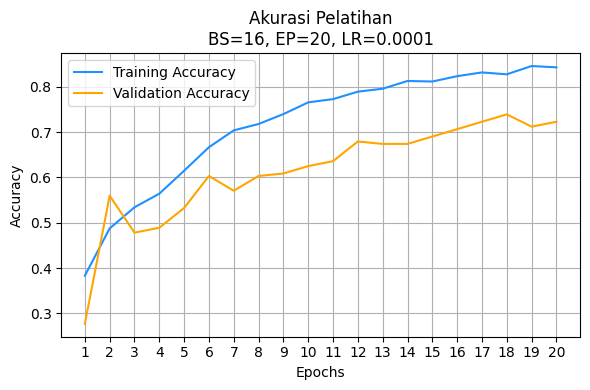

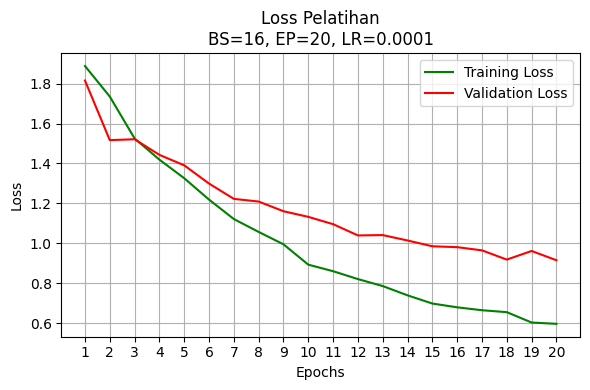

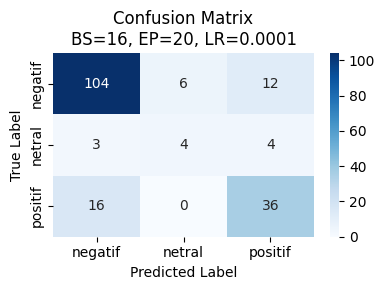


[2] Training with BS=16, Epoch=20, LR=0.0003, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.3808 - loss: 1.8433 - val_accuracy: 0.5272 - val_loss: 1.4297
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5618 - loss: 1.3914 - val_accuracy: 0.4946 - val_loss: 1.4137
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.6530 - loss: 1.1691 - val_accuracy: 0.5978 - val_loss: 1.2314
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.6970 - loss: 1.0090 - val_accuracy: 0.5652 - val_loss: 1.1455
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7437 - loss: 0.8705 - val_accuracy: 0.6087 - val_loss: 1.1832
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7931 - loss: 0.7322 - val_accuracy: 0.6630 - val_loss: 0.9636
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.7901 - loss: 0.7132 - val_accuracy: 0.6793 - val_loss: 0.9559
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8029 - loss: 0.6477 - val

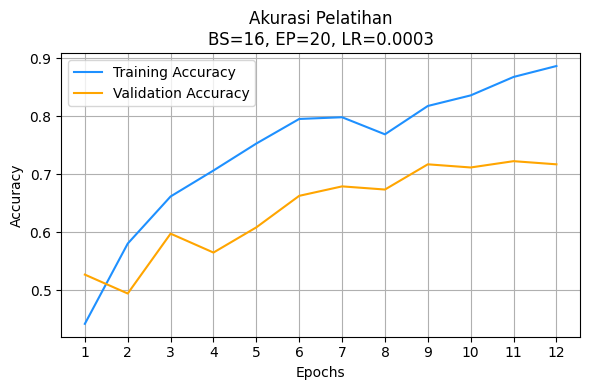

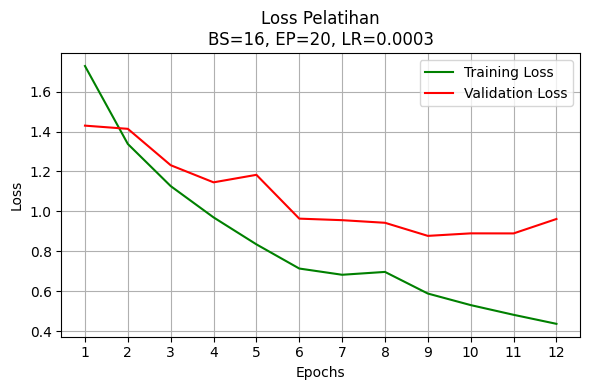

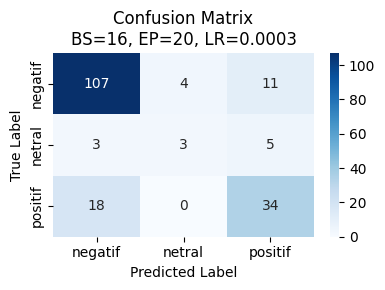


[3] Training with BS=16, Epoch=20, LR=0.0005, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.4117 - loss: 1.7643 - val_accuracy: 0.5272 - val_loss: 1.4692
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6150 - loss: 1.2460 - val_accuracy: 0.5380 - val_loss: 1.3152
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.7186 - loss: 0.9759 - val_accuracy: 0.6685 - val_loss: 1.0339
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7439 - loss: 0.8338 - val_accuracy: 0.6522 - val_loss: 1.0310
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.7807 - loss: 0.7189 - val_accuracy: 0.6522 - val_loss: 0.9811
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.7804 - loss: 0.6851 - val_accuracy: 0.6739 - val_loss: 0.9409
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.7981 - loss: 0.6195 - val_accuracy: 0.6576 - val_loss: 0.9891
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.8230 - loss: 0.5658 - va

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step


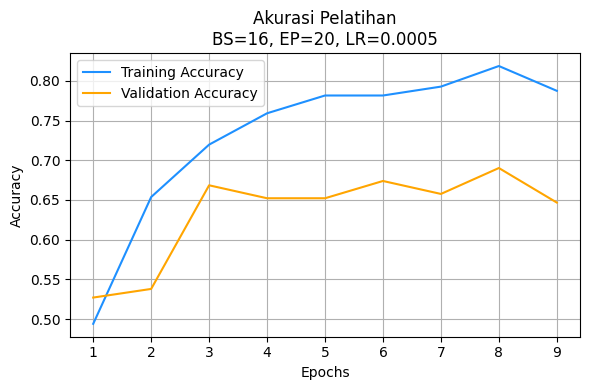

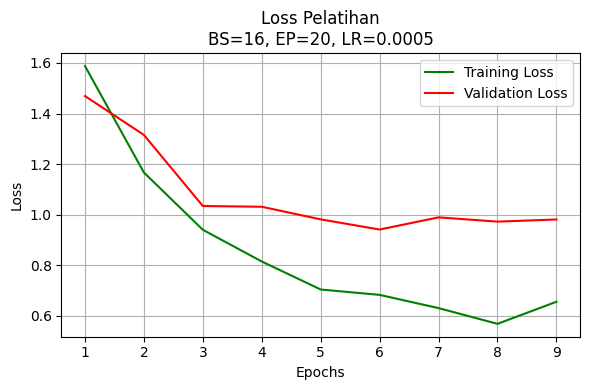

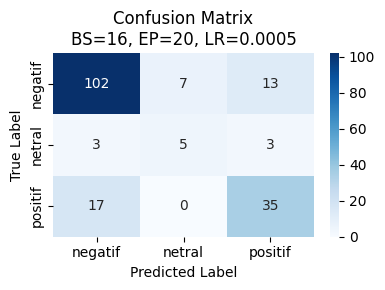


[4] Training with BS=16, Epoch=25, LR=0.0001, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.3637 - loss: 1.9217 - val_accuracy: 0.4348 - val_loss: 1.8117
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.4913 - loss: 1.7494 - val_accuracy: 0.4457 - val_loss: 1.5958
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5529 - loss: 1.5394 - val_accuracy: 0.4674 - val_loss: 1.5496
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.5418 - loss: 1.4394 - val_accuracy: 0.5000 - val_loss: 1.4725
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.5613 - loss: 1.3652 - val_accuracy: 0.4728 - val_loss: 1.4220
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6388 - loss: 1.2627 - val_accuracy: 0.5761 - val_loss: 1.3511
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.6746 - loss: 1.1929 - val_accuracy: 0.5978 - val_loss: 1.2670
Epoch 8/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7232 - loss: 1.0844 - val_

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


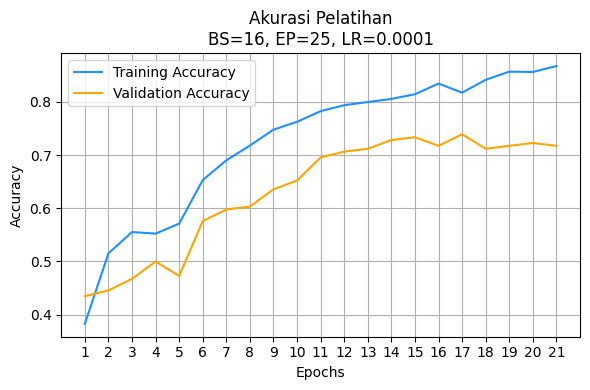

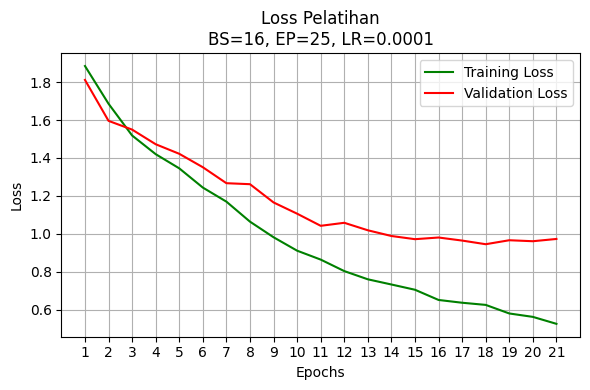

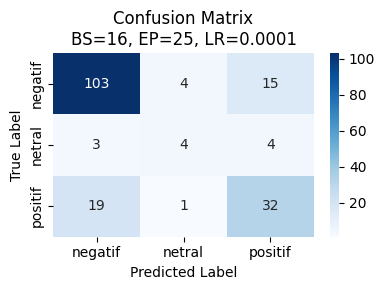


[5] Training with BS=16, Epoch=25, LR=0.0003, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.3987 - loss: 1.8248 - val_accuracy: 0.4891 - val_loss: 1.4608
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.5396 - loss: 1.4296 - val_accuracy: 0.4946 - val_loss: 1.3660
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.6045 - loss: 1.2046 - val_accuracy: 0.5272 - val_loss: 1.2818
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.7172 - loss: 0.9918 - val_accuracy: 0.6141 - val_loss: 1.1398
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7688 - loss: 0.8267 - val_accuracy: 0.6848 - val_loss: 0.9850
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.7811 - loss: 0.7479 - val_accuracy: 0.6522 - val_loss: 1.0134
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8034 - loss: 0.6790 - val_accuracy: 0.7391 - val_loss: 0.8932
Epoch 8/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.7965 - loss: 0.6785 - val

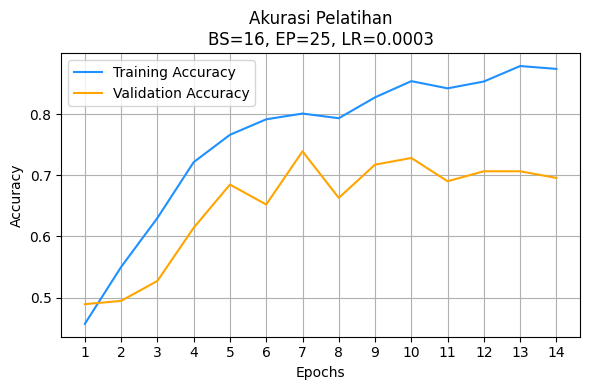

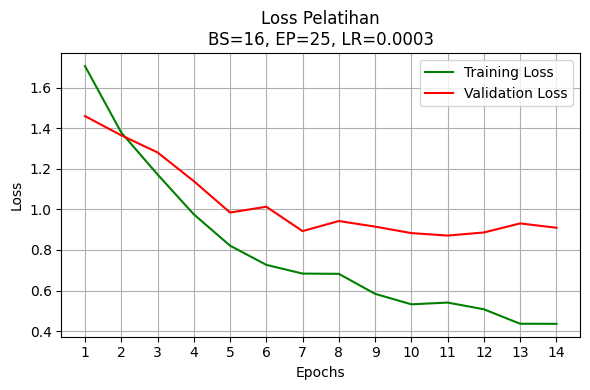

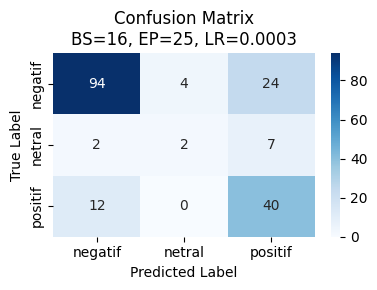


[6] Training with BS=16, Epoch=25, LR=0.0005, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.3788 - loss: 1.7636 - val_accuracy: 0.5054 - val_loss: 1.3646
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.5851 - loss: 1.2507 - val_accuracy: 0.5163 - val_loss: 1.3250
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.6647 - loss: 1.0258 - val_accuracy: 0.5870 - val_loss: 1.1286
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7469 - loss: 0.8141 - val_accuracy: 0.6141 - val_loss: 1.1307
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.8020 - loss: 0.6636 - val_accuracy: 0.6685 - val_loss: 0.9079
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8012 - loss: 0.6452 - val_accuracy: 0.6250 - val_loss: 0.9945
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.7976 - loss: 0.6648 - val_accuracy: 0.6087 - val_loss: 1.1039
Epoch 8/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.8201 - loss: 0.5980 - v

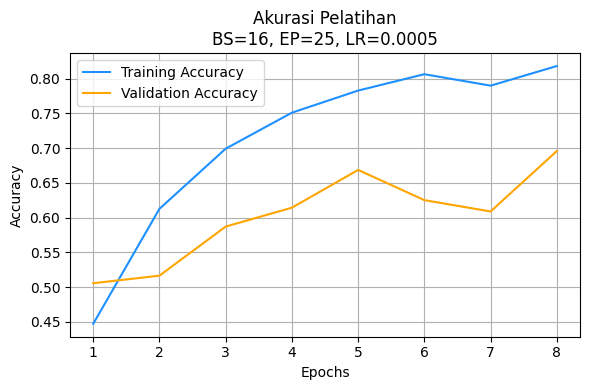

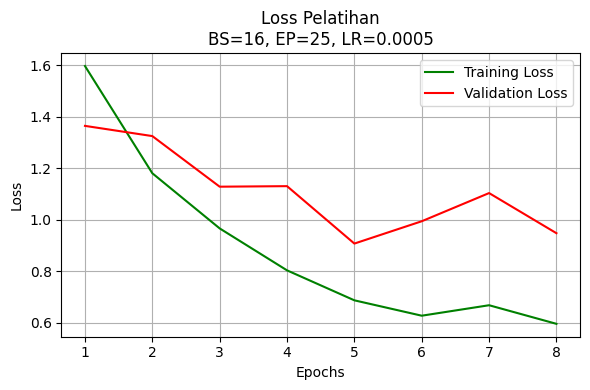

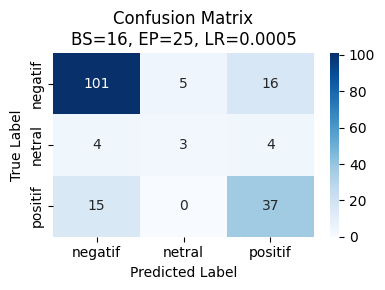


[7] Training with BS=16, Epoch=30, LR=0.0001, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.3580 - loss: 1.8915 - val_accuracy: 0.6033 - val_loss: 1.7643
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.5101 - loss: 1.7272 - val_accuracy: 0.5598 - val_loss: 1.5103
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5188 - loss: 1.5482 - val_accuracy: 0.5109 - val_loss: 1.4501
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.5662 - loss: 1.4179 - val_accuracy: 0.5109 - val_loss: 1.4173
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6000 - loss: 1.3035 - val_accuracy: 0.5543 - val_loss: 1.3109
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.6329 - loss: 1.2048 - val_accuracy: 0.5978 - val_loss: 1.2561
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.7038 - loss: 1.0924 - val_accuracy: 0.5978 - val_loss: 1.1715
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7273 - loss: 1.0252 - 

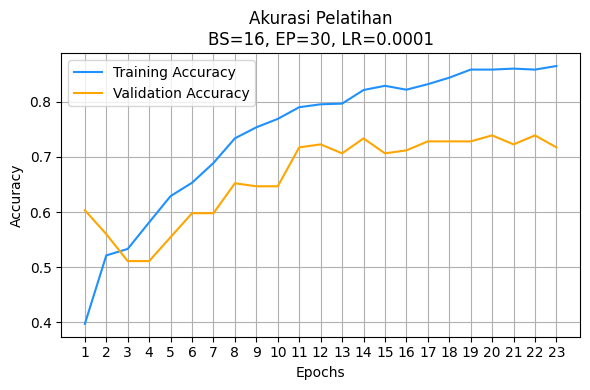

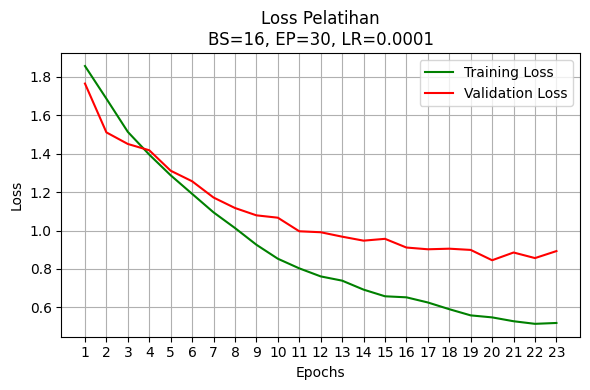

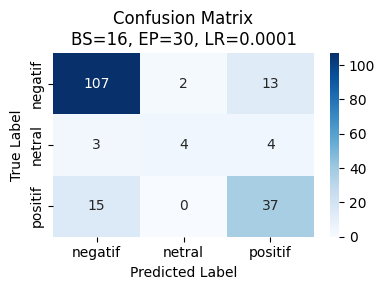


[8] Training with BS=16, Epoch=30, LR=0.0003, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.4137 - loss: 1.8303 - val_accuracy: 0.5380 - val_loss: 1.4150
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.5373 - loss: 1.4267 - val_accuracy: 0.4946 - val_loss: 1.3146
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6222 - loss: 1.1510 - val_accuracy: 0.5707 - val_loss: 1.2898
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.7249 - loss: 0.9935 - val_accuracy: 0.6196 - val_loss: 1.0224
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.7772 - loss: 0.8406 - val_accuracy: 0.6359 - val_loss: 1.0398
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.8005 - loss: 0.7230 - val_accuracy: 0.6304 - val_loss: 1.0066
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.8219 - loss: 0.6731 - val_accuracy: 0.6957 - val_loss: 0.9356
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.7994 - loss: 0.6887 - 

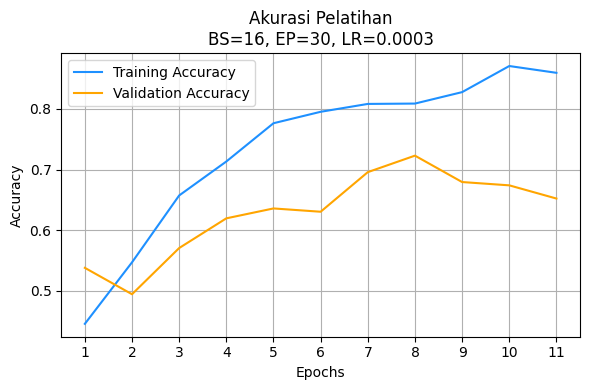

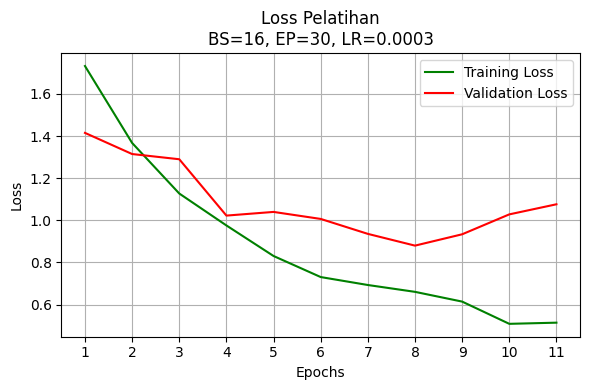

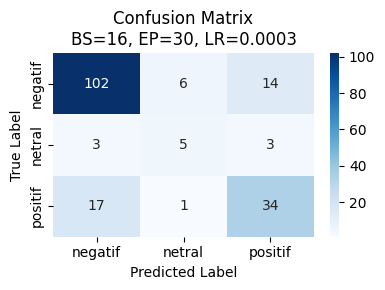


[9] Training with BS=16, Epoch=30, LR=0.0005, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.3522 - loss: 1.7935 - val_accuracy: 0.4946 - val_loss: 1.3368
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.5606 - loss: 1.2564 - val_accuracy: 0.5163 - val_loss: 1.1908
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.6616 - loss: 0.9970 - val_accuracy: 0.6467 - val_loss: 1.0009
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.7502 - loss: 0.7959 - val_accuracy: 0.6522 - val_loss: 0.9461
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.7482 - loss: 0.7587 - val_accuracy: 0.6685 - val_loss: 0.8942
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.7846 - loss: 0.6551 - val_accuracy: 0.7065 - val_loss: 0.9166
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.8037 - loss: 0.5899 - val_accuracy: 0.6522 - val_loss: 0.9414
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.7982 - loss: 0.6206 - 

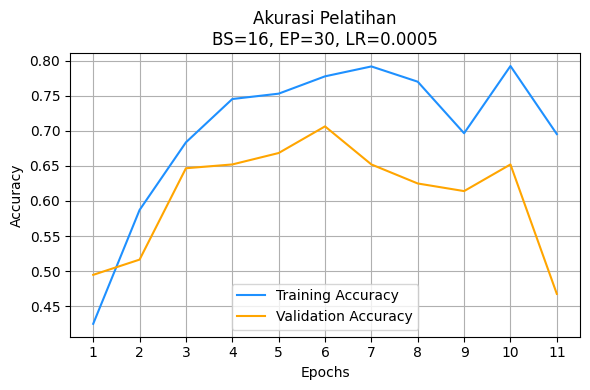

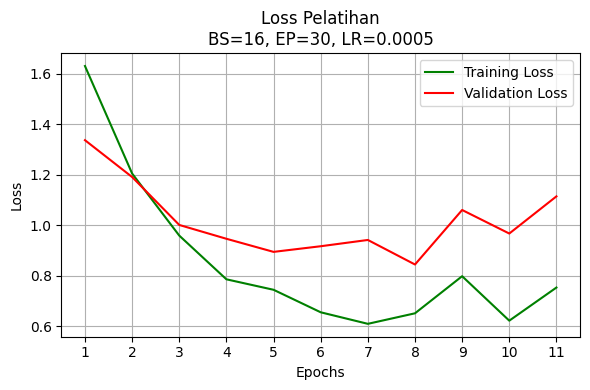

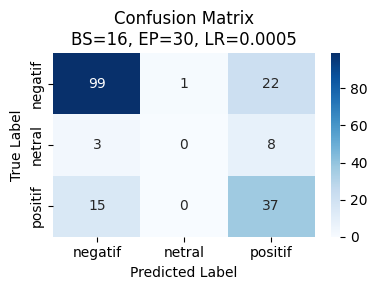


[10] Training with BS=32, Epoch=20, LR=0.0001, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.3687 - loss: 1.9216 - val_accuracy: 0.2228 - val_loss: 1.8639
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.4101 - loss: 1.8461 - val_accuracy: 0.2772 - val_loss: 1.7861
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.4940 - loss: 1.7620 - val_accuracy: 0.5543 - val_loss: 1.5877
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.5284 - loss: 1.6034 - val_accuracy: 0.4891 - val_loss: 1.5584
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.5595 - loss: 1.5192 - val_accuracy: 0.5163 - val_loss: 1.5144
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.5995 - loss: 1.4348 - val_accuracy: 0.5870 - val_loss: 1.4078
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.6570 - loss: 1.3569 - val_accuracy: 0.5978 - val_loss: 1.3705
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.6876 - loss: 1.2922 - val_accuracy: 0.608

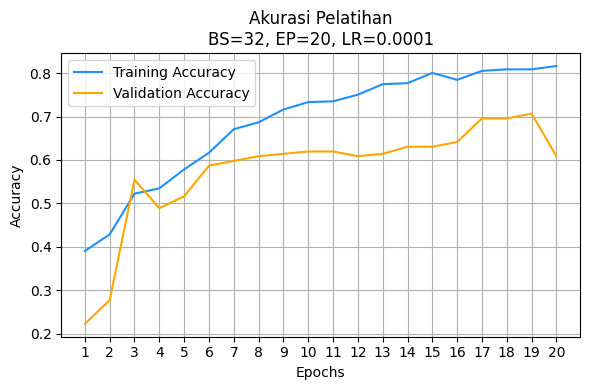

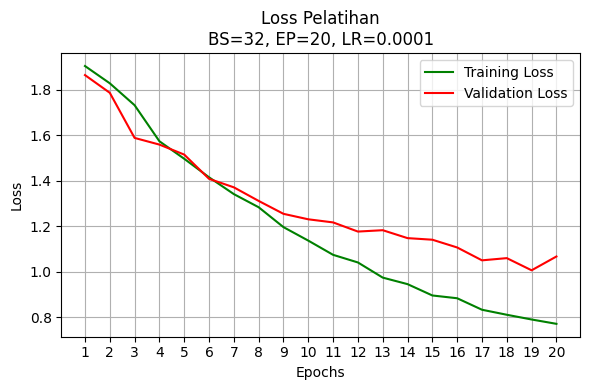

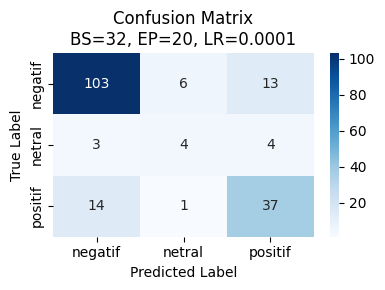


[11] Training with BS=32, Epoch=20, LR=0.0003, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.3492 - loss: 1.8725 - val_accuracy: 0.5598 - val_loss: 1.5584
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.5278 - loss: 1.5786 - val_accuracy: 0.4674 - val_loss: 1.5156
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.5842 - loss: 1.3776 - val_accuracy: 0.6087 - val_loss: 1.2902
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.6326 - loss: 1.2133 - val_accuracy: 0.5978 - val_loss: 1.1946
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.7088 - loss: 1.0750 - val_accuracy: 0.6141 - val_loss: 1.1342
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7608 - loss: 0.9170 - val_accuracy: 0.6087 - val_loss: 1.1197
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.7704 - loss: 0.8246 - val_accuracy: 0.5978 - val_loss: 1.0893
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.7874 - loss: 0.7629 - val_accuracy: 0.

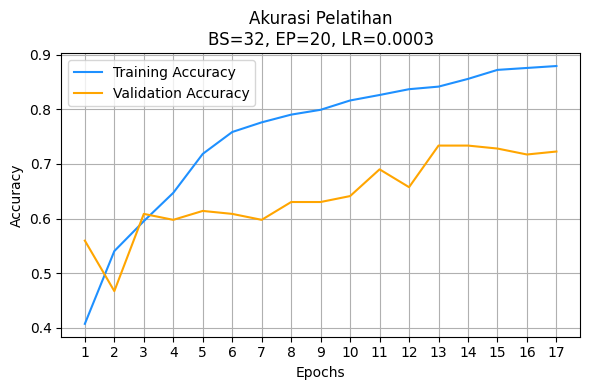

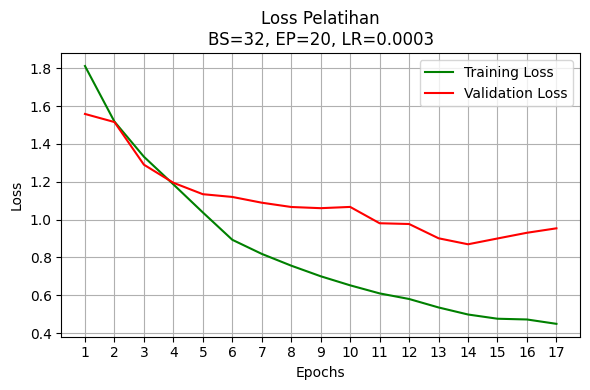

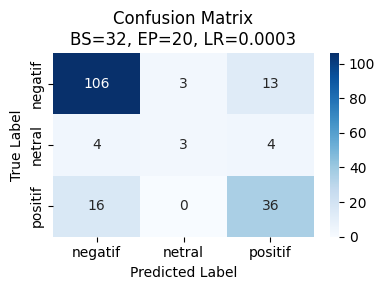


[12] Training with BS=32, Epoch=20, LR=0.0005, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.3775 - loss: 1.8496 - val_accuracy: 0.3424 - val_loss: 1.6339
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5164 - loss: 1.4749 - val_accuracy: 0.4565 - val_loss: 1.4340
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.5609 - loss: 1.2609 - val_accuracy: 0.4946 - val_loss: 1.2730
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.6670 - loss: 1.0888 - val_accuracy: 0.6033 - val_loss: 1.1847
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.7412 - loss: 0.8945 - val_accuracy: 0.6576 - val_loss: 1.0184
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.7779 - loss: 0.7659 - val_accuracy: 0.7174 - val_loss: 0.9540
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.8023 - loss: 0.6975 - val_accuracy: 0.7337 - val_loss: 0.9181
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8299 - loss: 0.6111 - val_accuracy: 0.7

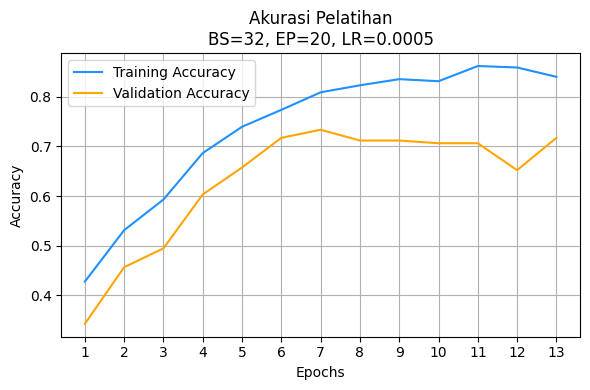

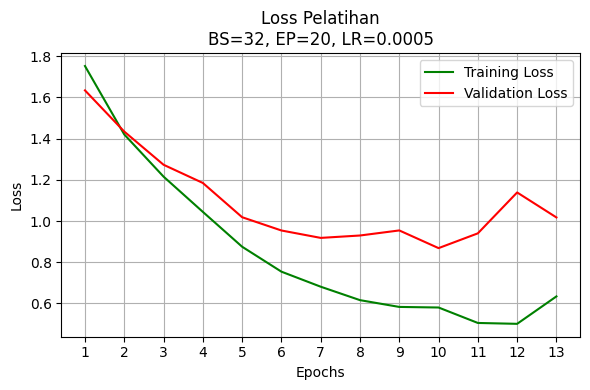

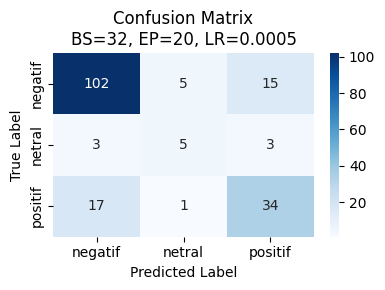


[13] Training with BS=32, Epoch=25, LR=0.0001, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.3263 - loss: 1.9361 - val_accuracy: 0.1739 - val_loss: 1.8822
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.4234 - loss: 1.8584 - val_accuracy: 0.3750 - val_loss: 1.8010
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.4924 - loss: 1.7453 - val_accuracy: 0.5054 - val_loss: 1.6094
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5185 - loss: 1.5928 - val_accuracy: 0.4946 - val_loss: 1.5922
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.5451 - loss: 1.5300 - val_accuracy: 0.5000 - val_loss: 1.5604
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.5429 - loss: 1.4739 - val_accuracy: 0.5380 - val_loss: 1.4889
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.5776 - loss: 1.3987 - val_accuracy: 0.5326 - val_loss: 1.4545
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.6152 - loss: 1.3082 - val_accuracy: 0.5

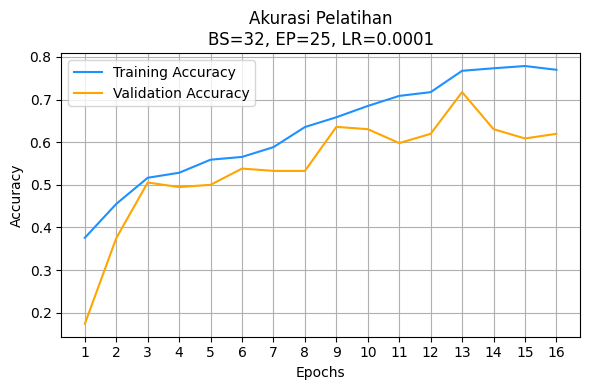

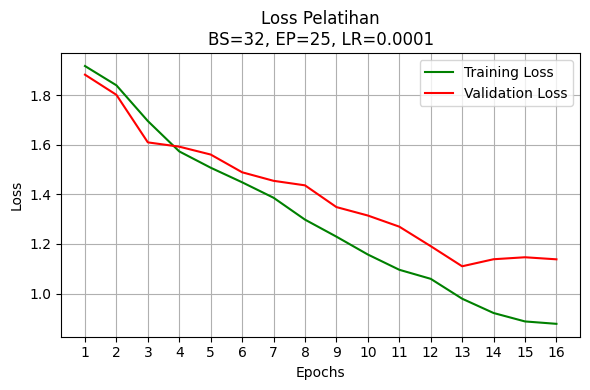

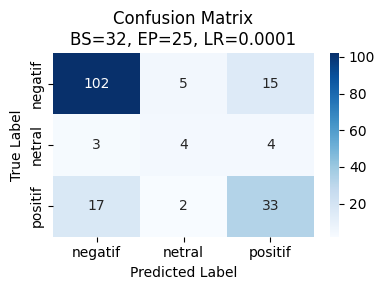


[14] Training with BS=32, Epoch=25, LR=0.0003, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.3434 - loss: 1.8847 - val_accuracy: 0.6685 - val_loss: 1.5839
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.5030 - loss: 1.6263 - val_accuracy: 0.4620 - val_loss: 1.4782
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.5488 - loss: 1.4279 - val_accuracy: 0.5380 - val_loss: 1.3662
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.5951 - loss: 1.2465 - val_accuracy: 0.6087 - val_loss: 1.2685
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.6943 - loss: 1.0814 - val_accuracy: 0.6141 - val_loss: 1.1532
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.7518 - loss: 0.9293 - val_accuracy: 0.6250 - val_loss: 1.0684
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7793 - loss: 0.8218 - val_accuracy: 0.6685 - val_loss: 1.0035
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.7952 - loss: 0.7526 - val_accuracy: 0.

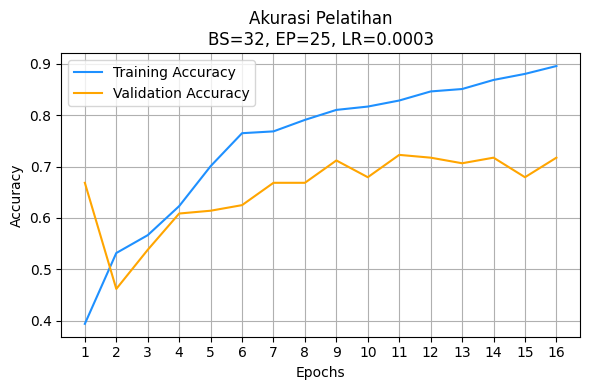

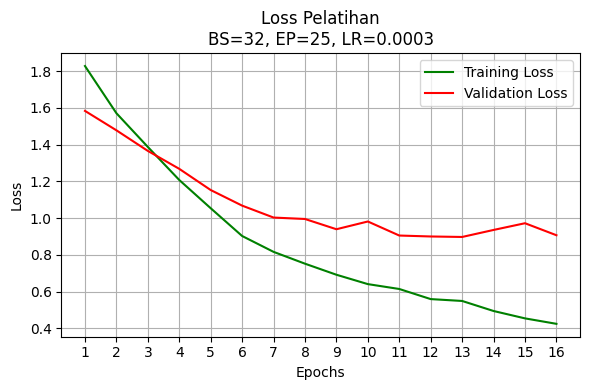

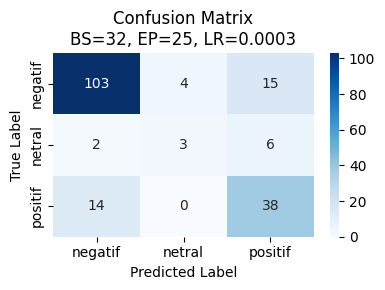


[15] Training with BS=32, Epoch=25, LR=0.0005, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.4023 - loss: 1.8511 - val_accuracy: 0.4130 - val_loss: 1.6420
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5443 - loss: 1.4489 - val_accuracy: 0.4891 - val_loss: 1.3757
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.6236 - loss: 1.2135 - val_accuracy: 0.6359 - val_loss: 1.2273
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7504 - loss: 0.9407 - val_accuracy: 0.6576 - val_loss: 1.1004
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.7641 - loss: 0.8209 - val_accuracy: 0.6630 - val_loss: 0.9521
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7729 - loss: 0.7406 - val_accuracy: 0.6141 - val_loss: 1.1165
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.7999 - loss: 0.6732 - val_accuracy: 0.6522 - val_loss: 1.0525
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.7995 - loss: 0.6257 - val_accuracy: 0.

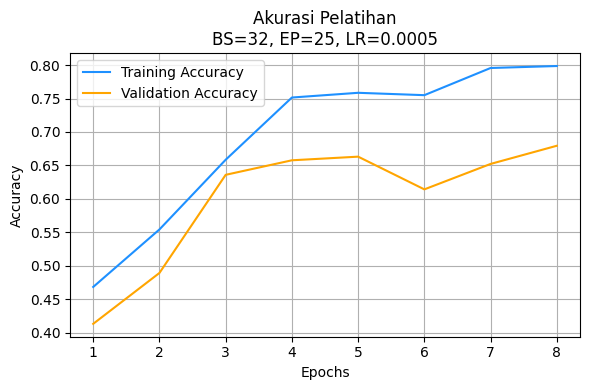

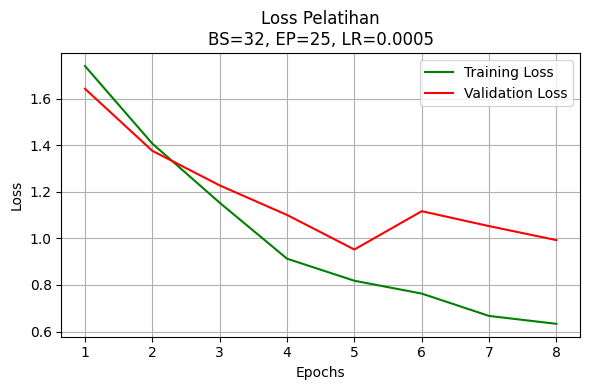

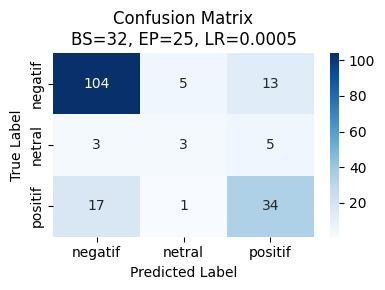


[16] Training with BS=32, Epoch=30, LR=0.0001, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.3364 - loss: 1.9200 - val_accuracy: 0.2337 - val_loss: 1.8649
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.4144 - loss: 1.8449 - val_accuracy: 0.2880 - val_loss: 1.7900
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.4814 - loss: 1.7679 - val_accuracy: 0.5761 - val_loss: 1.5649
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.5254 - loss: 1.6201 - val_accuracy: 0.4946 - val_loss: 1.5350
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.5704 - loss: 1.5121 - val_accuracy: 0.5054 - val_loss: 1.4890
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.5896 - loss: 1.4440 - val_accuracy: 0.5272 - val_loss: 1.4501
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.6424 - loss: 1.3544 - val_accuracy: 0.5652 - val_loss: 1.4262
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.6655 - loss: 1.3020 - val_accuracy: 0.5

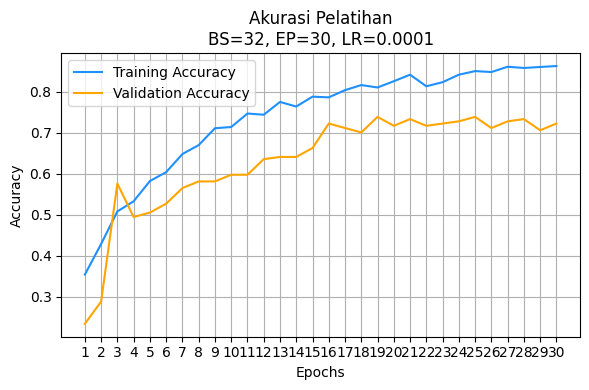

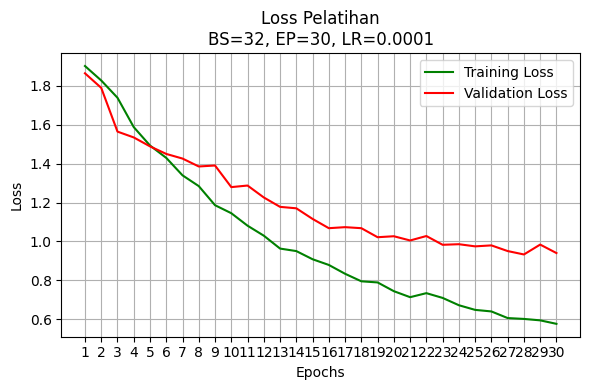

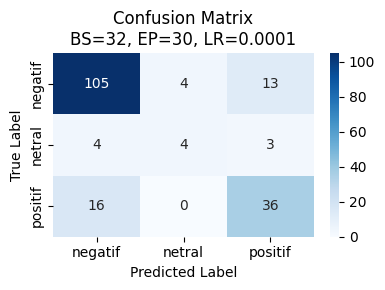


[17] Training with BS=32, Epoch=30, LR=0.0003, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.4102 - loss: 1.8897 - val_accuracy: 0.5652 - val_loss: 1.5560
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.5346 - loss: 1.5817 - val_accuracy: 0.4239 - val_loss: 1.5568
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.5561 - loss: 1.4200 - val_accuracy: 0.4783 - val_loss: 1.4597
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.6032 - loss: 1.2830 - val_accuracy: 0.5380 - val_loss: 1.3660
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.6834 - loss: 1.1145 - val_accuracy: 0.5761 - val_loss: 1.1816
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.7416 - loss: 0.9655 - val_accuracy: 0.5978 - val_loss: 1.1851
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.7697 - loss: 0.8708 - val_accuracy: 0.6685 - val_loss: 1.0092
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8048 - loss: 0.7578 - val_accuracy: 0

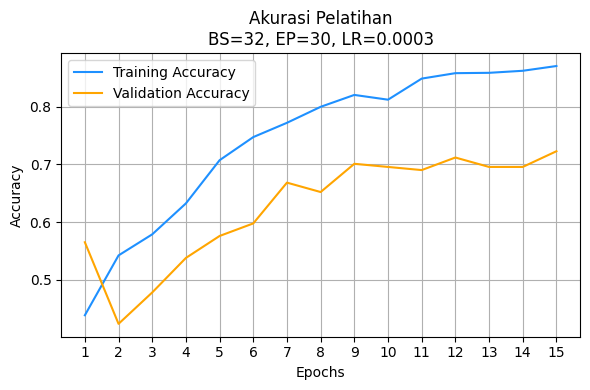

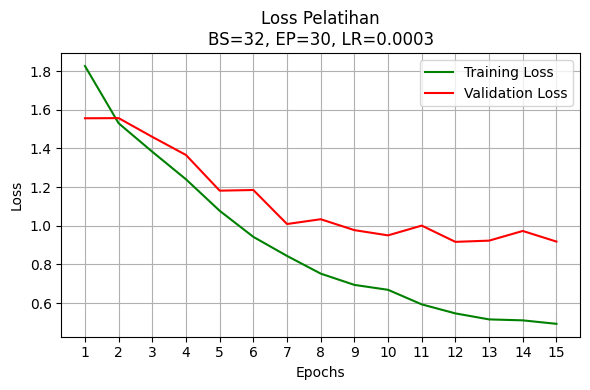

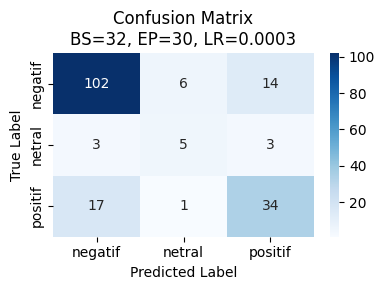


[18] Training with BS=32, Epoch=30, LR=0.0005, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.3616 - loss: 1.8542 - val_accuracy: 0.4022 - val_loss: 1.6396
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.5037 - loss: 1.4807 - val_accuracy: 0.4891 - val_loss: 1.4321
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.5792 - loss: 1.2642 - val_accuracy: 0.5652 - val_loss: 1.2169
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.6984 - loss: 1.0288 - val_accuracy: 0.6359 - val_loss: 1.1505
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7593 - loss: 0.8354 - val_accuracy: 0.6630 - val_loss: 0.9818
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.7985 - loss: 0.7183 - val_accuracy: 0.6467 - val_loss: 0.9702
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8055 - loss: 0.6730 - val_accuracy: 0.6522 - val_loss: 1.0263
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.8040 - loss: 0.6206 - val_accuracy: 

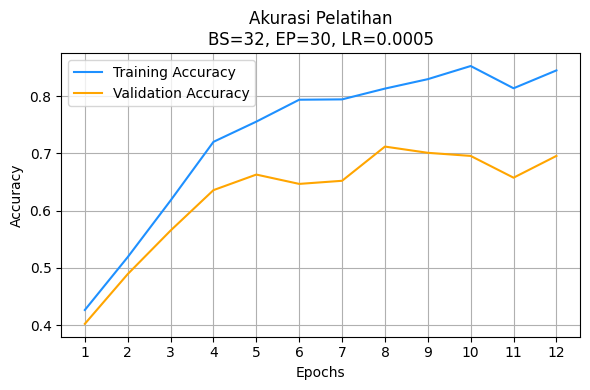

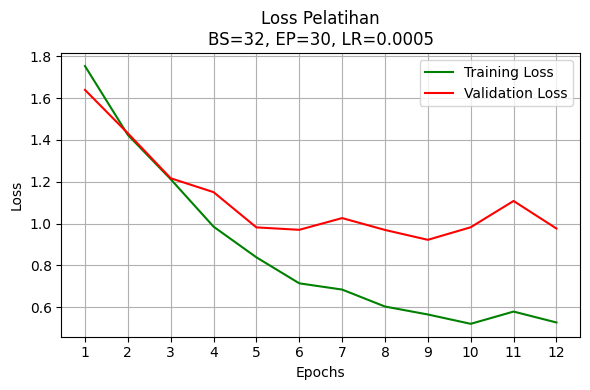

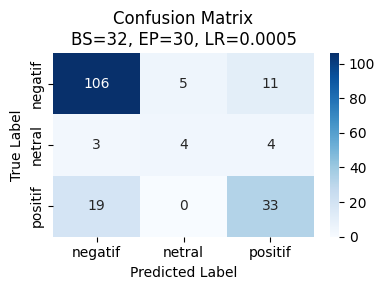


[19] Training with BS=64, Epoch=20, LR=0.0001, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.3910 - loss: 1.9386 - val_accuracy: 0.3967 - val_loss: 1.9049
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.4199 - loss: 1.8967 - val_accuracy: 0.2609 - val_loss: 1.8660
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.4549 - loss: 1.8569 - val_accuracy: 0.3478 - val_loss: 1.8158
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.4508 - loss: 1.8085 - val_accuracy: 0.5272 - val_loss: 1.7150
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.4974 - loss: 1.7300 - val_accuracy: 0.5000 - val_loss: 1.6162
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.5276 - loss: 1.6520 - val_accuracy: 0.4457 - val_loss: 1.6512
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.5254 - loss: 1.5917 - val_accuracy: 0.4891 - val_loss: 1.6056
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.5364 - loss: 1.5348 - val_accuracy: 0.

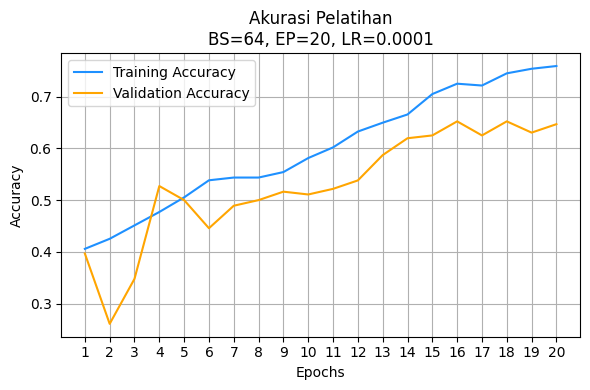

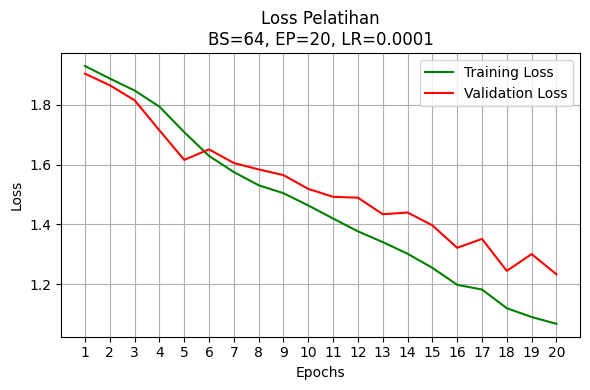

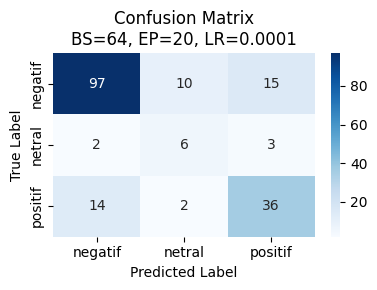


[20] Training with BS=64, Epoch=20, LR=0.0003, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.3568 - loss: 1.9000 - val_accuracy: 0.1957 - val_loss: 1.8258
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.4418 - loss: 1.7739 - val_accuracy: 0.5435 - val_loss: 1.5738
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.5382 - loss: 1.5720 - val_accuracy: 0.5272 - val_loss: 1.5053
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5747 - loss: 1.4499 - val_accuracy: 0.5272 - val_loss: 1.4416
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6040 - loss: 1.3271 - val_accuracy: 0.5272 - val_loss: 1.4002
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.6268 - loss: 1.2270 - val_accuracy: 0.5815 - val_loss: 1.2924
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.7047 - loss: 1.1010 - val_accuracy: 0.6141 - val_loss: 1.2777
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.7575 - loss: 0.9836 - val_accuracy: 0

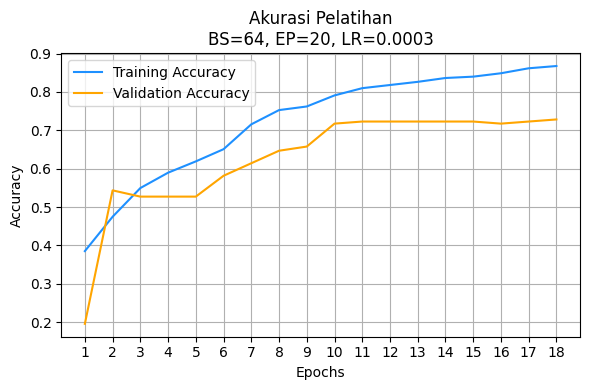

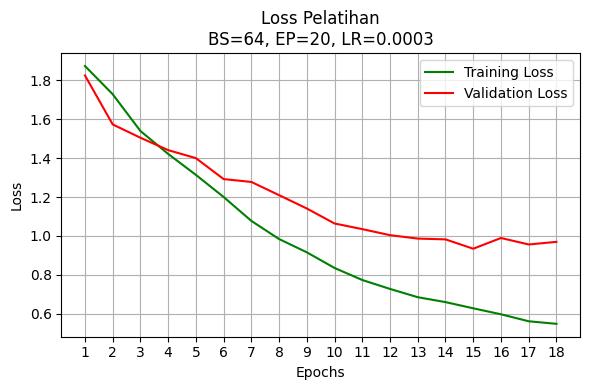

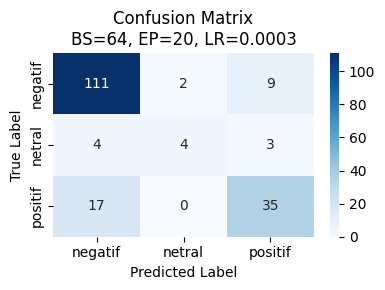


[21] Training with BS=64, Epoch=20, LR=0.0005, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.3733 - loss: 1.9159 - val_accuracy: 0.4293 - val_loss: 1.7315
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.5104 - loss: 1.6442 - val_accuracy: 0.5000 - val_loss: 1.5693
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.5672 - loss: 1.4527 - val_accuracy: 0.5272 - val_loss: 1.4548
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.6237 - loss: 1.3115 - val_accuracy: 0.5870 - val_loss: 1.3023
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.7086 - loss: 1.1231 - val_accuracy: 0.6250 - val_loss: 1.1872
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7432 - loss: 0.9931 - val_accuracy: 0.6522 - val_loss: 1.1135
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7889 - loss: 0.8639 - val_accuracy: 0.6413 - val_loss: 1.1433
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.8134 - loss: 0.7690 - val_accuracy: 0

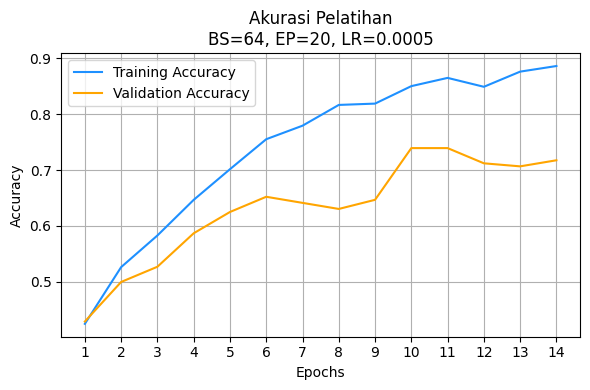

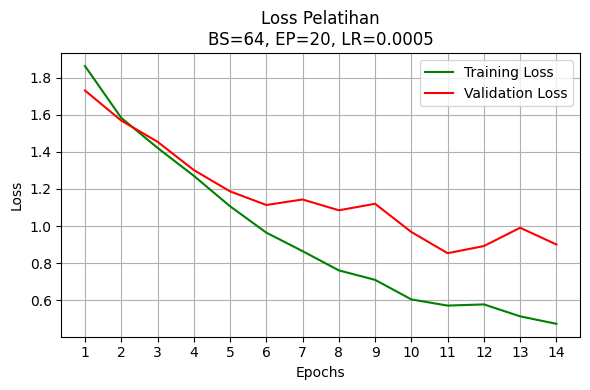

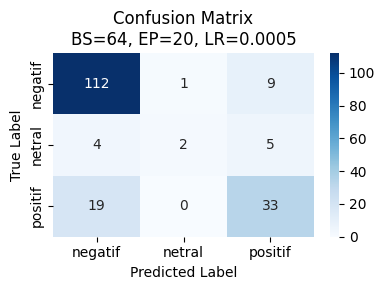


[22] Training with BS=64, Epoch=25, LR=0.0001, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - accuracy: 0.3450 - loss: 1.9442 - val_accuracy: 0.3261 - val_loss: 1.9170
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.3738 - loss: 1.9039 - val_accuracy: 0.3533 - val_loss: 1.8821
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.4211 - loss: 1.8645 - val_accuracy: 0.3641 - val_loss: 1.8459
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.4655 - loss: 1.8232 - val_accuracy: 0.4728 - val_loss: 1.7946
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4951 - loss: 1.7611 - val_accuracy: 0.5000 - val_loss: 1.6293
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5245 - loss: 1.6341 - val_accuracy: 0.4293 - val_loss: 1.7050
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.5383 - loss: 1.5810 - val_accuracy: 0.5054 - val_loss: 1.5906
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.5345 - loss: 1.5517 - val_accuracy: 0

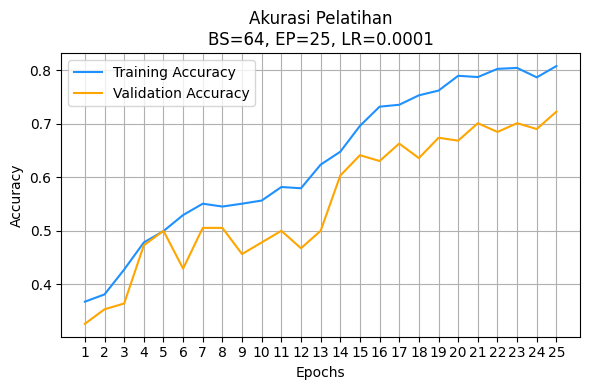

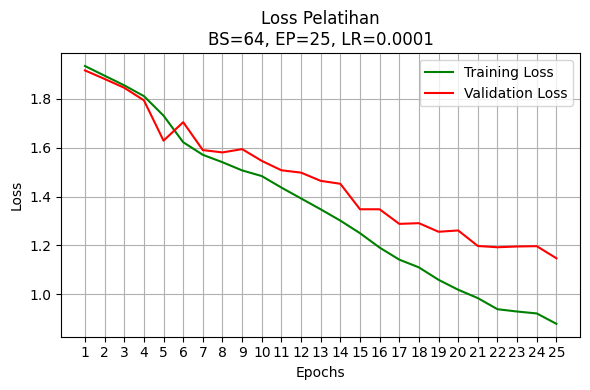

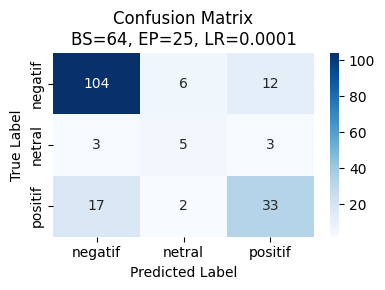


[23] Training with BS=64, Epoch=25, LR=0.0003, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.3555 - loss: 1.9241 - val_accuracy: 0.3641 - val_loss: 1.8330
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.4595 - loss: 1.7955 - val_accuracy: 0.5380 - val_loss: 1.5499
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.5367 - loss: 1.6109 - val_accuracy: 0.5163 - val_loss: 1.5481
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.5652 - loss: 1.4655 - val_accuracy: 0.5870 - val_loss: 1.5026
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.6223 - loss: 1.3972 - val_accuracy: 0.5870 - val_loss: 1.4321
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.6567 - loss: 1.2722 - val_accuracy: 0.5761 - val_loss: 1.4003
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.7296 - loss: 1.1414 - val_accuracy: 0.5598 - val_loss: 1.3979
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7272 - loss: 1.0647 - val_accuracy: 0

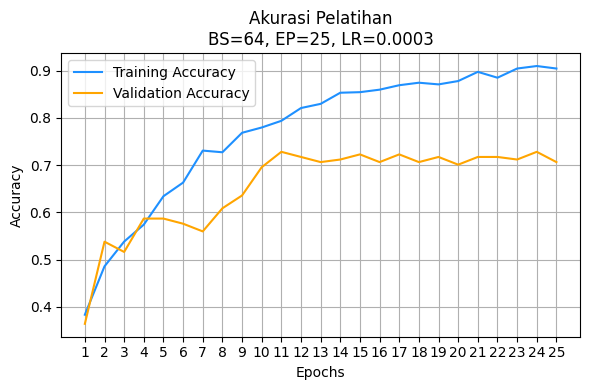

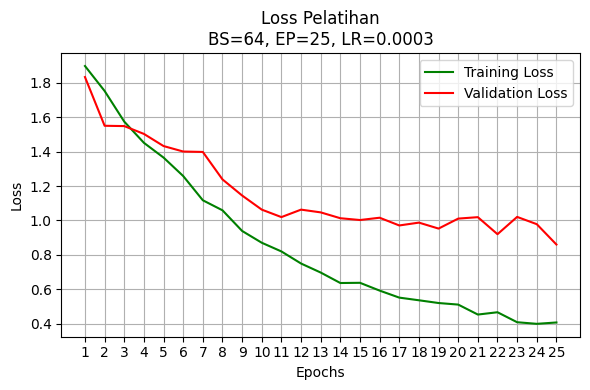

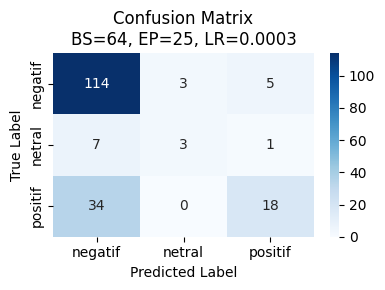


[24] Training with BS=64, Epoch=25, LR=0.0005, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.3350 - loss: 1.9076 - val_accuracy: 0.2609 - val_loss: 1.7618
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.4531 - loss: 1.6911 - val_accuracy: 0.4837 - val_loss: 1.5250
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.5377 - loss: 1.4692 - val_accuracy: 0.6250 - val_loss: 1.3976
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.6251 - loss: 1.2932 - val_accuracy: 0.6033 - val_loss: 1.3139
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.6758 - loss: 1.1390 - val_accuracy: 0.6033 - val_loss: 1.2738
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7186 - loss: 1.0249 - val_accuracy: 0.6304 - val_loss: 1.1460
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.7630 - loss: 0.9045 - val_accuracy: 0.6033 - val_loss: 1.1669
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.7754 - loss: 0.8237 - val_accuracy: 0.

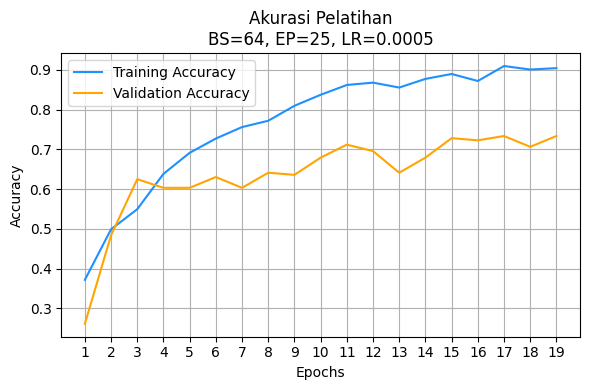

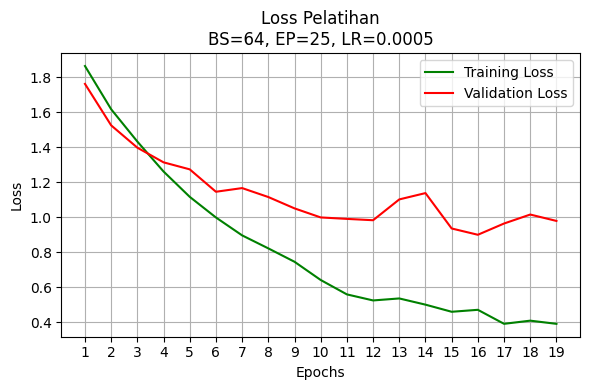

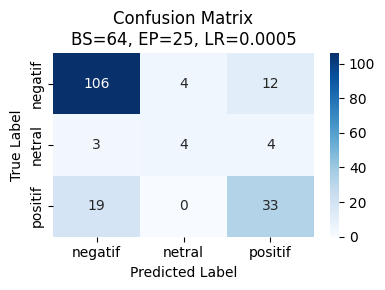


[25] Training with BS=64, Epoch=30, LR=0.0001, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.3420 - loss: 1.9515 - val_accuracy: 0.3261 - val_loss: 1.9177
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.3878 - loss: 1.9100 - val_accuracy: 0.3913 - val_loss: 1.8768
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.4019 - loss: 1.8707 - val_accuracy: 0.3913 - val_loss: 1.8319
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.4624 - loss: 1.8218 - val_accuracy: 0.5543 - val_loss: 1.7223
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.4962 - loss: 1.7352 - val_accuracy: 0.4348 - val_loss: 1.6405
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.5177 - loss: 1.6456 - val_accuracy: 0.4511 - val_loss: 1.6565
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5248 - loss: 1.5876 - val_accuracy: 0.5109 - val_loss: 1.6025
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.5356 - loss: 1.5565 - val_accuracy: 0

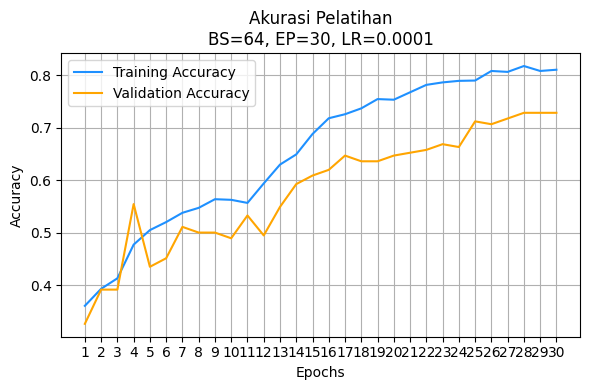

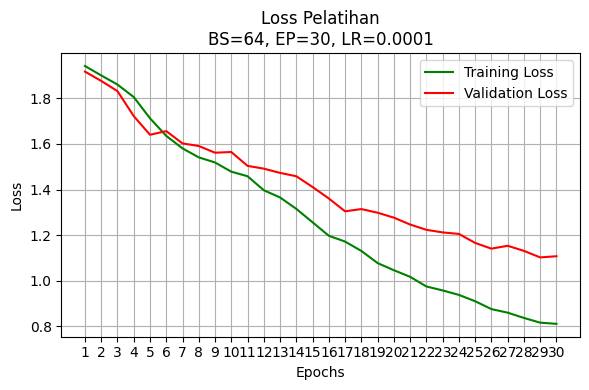

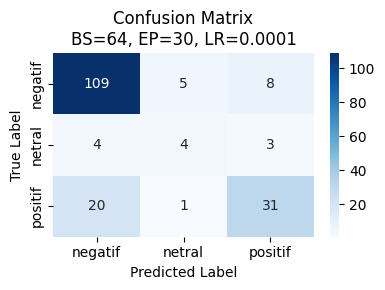


[26] Training with BS=64, Epoch=30, LR=0.0003, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.3428 - loss: 1.9174 - val_accuracy: 0.4022 - val_loss: 1.8237
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.4513 - loss: 1.7988 - val_accuracy: 0.5761 - val_loss: 1.6218
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.5393 - loss: 1.6133 - val_accuracy: 0.5435 - val_loss: 1.5382
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6231 - loss: 1.4616 - val_accuracy: 0.5217 - val_loss: 1.4787
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.6533 - loss: 1.3219 - val_accuracy: 0.5543 - val_loss: 1.4426
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.6887 - loss: 1.2165 - val_accuracy: 0.5815 - val_loss: 1.3287
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7325 - loss: 1.1157 - val_accuracy: 0.6196 - val_loss: 1.2607
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.7557 - loss: 1.0338 - val_accuracy: 0

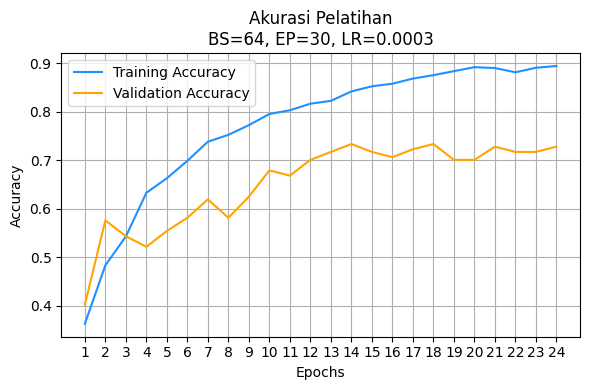

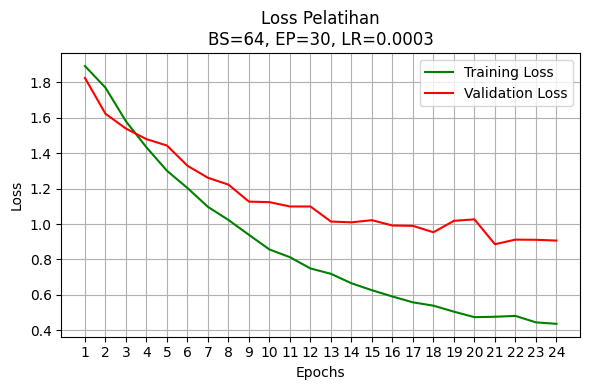

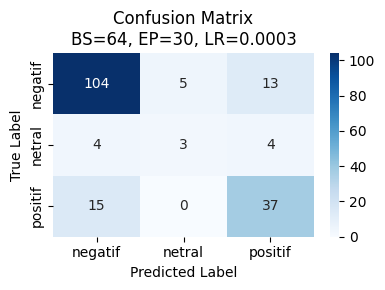


[27] Training with BS=64, Epoch=30, LR=0.0005, LSTM=128, Dense=64, Dropout=0.5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 50, 100)        │       183,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,999 (1.18 MB)

 Trainable params: 308,999 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.4043 - loss: 1.9186 - val_accuracy: 0.4402 - val_loss: 1.7339
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.5208 - loss: 1.6597 - val_accuracy: 0.5272 - val_loss: 1.5465
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6068 - loss: 1.4395 - val_accuracy: 0.5380 - val_loss: 1.4697
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.6714 - loss: 1.2550 - val_accuracy: 0.5870 - val_loss: 1.3513
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.7404 - loss: 1.0814 - val_accuracy: 0.6087 - val_loss: 1.2406
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7509 - loss: 1.0021 - val_accuracy: 0.5543 - val_loss: 1.2734
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.7748 - loss: 0.8968 - val_accuracy: 0.6250 - val_loss: 1.1434
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.8095 - loss: 0.7691 - val_accuracy: 0.

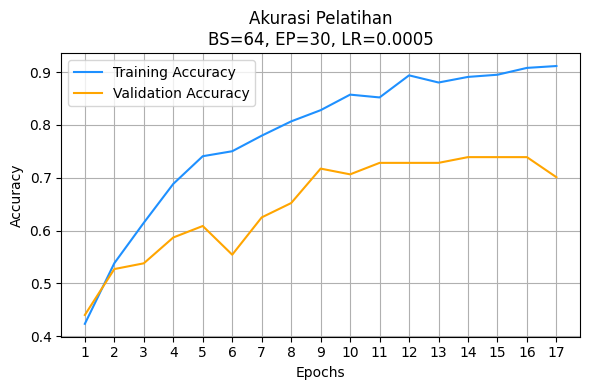

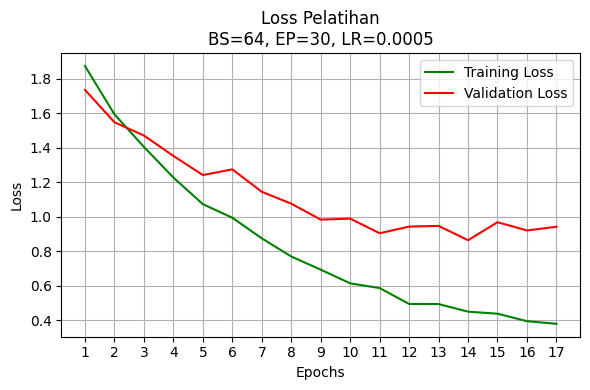

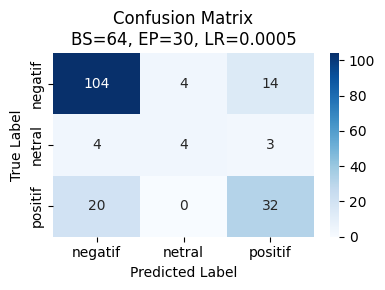


===== Percobaan 1 =====
BS: 16 | Epoch: 20 | LR: 0.0001 | LSTM: 128 | Dense: 64
Akurasi: 0.7784 | F1 Macro: 0.6407
Classification Report:
              precision    recall  f1-score   support

     negatif       0.85      0.85      0.85       122
      netral       0.40      0.36      0.38        11
     positif       0.69      0.69      0.69        52

    accuracy                           0.78       185
   macro avg       0.65      0.64      0.64       185
weighted avg       0.78      0.78      0.78       185


===== Percobaan 2 =====
BS: 16 | Epoch: 20 | LR: 0.0003 | LSTM: 128 | Dense: 64
Akurasi: 0.7784 | F1 Macro: 0.6187
Classification Report:
              precision    recall  f1-score   support

     negatif       0.84      0.88      0.86       122
      netral       0.43      0.27      0.33        11
     positif       0.68      0.65      0.67        52

    accuracy                           0.78       185
   macro avg       0.65      0.60      0.62       185
weighted avg   

In [ ]:
# Kombinasi eksperimen tunggal
batch_sizes = [16, 32, 64]
epochs_list = [20, 25, 30]
learning_rates = [0.0001, 0.0003, 0.0005]

results = []

for idx, (bs, ep, lr) in enumerate(itertools.product(batch_sizes, epochs_list, learning_rates)):

    print(f"\n[{idx+1}] Training with BS={bs}, Epoch={ep}, LR={lr}, LSTM=128, Dense=64, Dropout=0.5")

    # Buat ulang model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                  weights=[embedding_matrix], trainable=True),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2, recurrent_activation='sigmoid'),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    model.build(input_shape=(None, max_length))
    model.summary()

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Training
    history = model.fit(
        X_train_pad, Y_train_ohe,
        validation_data=(X_val_pad, Y_val_ohe),
        epochs=ep,
        batch_size=bs,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluasi
    y_pred_prob = model.predict(X_test_pad)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(Y_test_ohe, axis=1)

    acc = accuracy_score(y_true, y_pred)
    report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

    results.append({
        'batch_size': bs,
        'epochs': ep,
        'learning_rate': lr,
        'lstm_units': 128,
        'dense_units': 64,
        'accuracy': acc,
        'f1_macro': report_dict['macro avg']['f1-score'],
        'y_true': y_true,
        'y_pred': y_pred
    })

    # Buat range jumlah epoch aktual
    epochs_range = range(1, len(history.history['accuracy']) + 1)

    # Grafik 1: Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', color='dodgerblue')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Akurasi Pelatihan\nBS={bs}, EP={ep}, LR={lr}')
    plt.xticks(epochs_range)  # agar label X sesuai jumlah epoch
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Grafik 2: Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, history.history['loss'], label='Training Loss', color='green')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Pelatihan\nBS={bs}, EP={ep}, LR={lr}')
    plt.xticks(epochs_range)  # agar label X sesuai jumlah epoch
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix\nBS={bs}, EP={ep}, LR={lr}')
    plt.tight_layout()
    plt.show()

# Ringkasan semua percobaan
for i, res in enumerate(results):
    print(f"\n===== Percobaan {i+1} =====")
    print(f"BS: {res['batch_size']} | Epoch: {res['epochs']} | LR: {res['learning_rate']} | "
          f"LSTM: {res['lstm_units']} | Dense: {res['dense_units']}")
    print(f"Akurasi: {res['accuracy']:.4f} | F1 Macro: {res['f1_macro']:.4f}")
    print("Classification Report:")
    print(classification_report(res['y_true'], res['y_pred'], target_names=label_encoder.classes_))
